### Data Science Game 2017

Data fields

    media_id - identifiant of the song listened by the user
    album_id - identifiant of the album of the song
    media_duration - duration of the song
    user_gender -  gender of the user
    user_id -  anonymized id of the user
    context_type - type of content where the song was listened: playlist, album ...
    release_date - release date of the song with the format YYYYMMDD
    ts_listen - timestamp of the listening in UNIX time
    platform_name - type of os
    platform_family - type of device
    user_age - age of the user
    listen_type - if the songs was listened in a flow or not
    artist_id - identifiant of the artist of the song
    genre_id - identifiant of the genre of the song
    is_listened - 1 if the track was listened, 0 otherwise


In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv("../data/train_data4.csv")
df_test = pd.read_csv("../data/test_data4.csv")

df_train["user_id_id"] = df_train["user_id"]
df_test["user_id_id"] = df_test["user_id"]

In [3]:
len(df_train)
test_user_ids = df_test["user_id"].unique()
df_train["ts_listen"] = pd.to_datetime(df_train["ts_listen"] )
df_test["ts_listen"] = pd.to_datetime(df_test["ts_listen"] )


In [4]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

def delayed_data(data, delayed_columns, delays=1, start_delay=1):
    """ Retorna um Dataframe com o delay indicado aplicado na lista de colunas indicadas
    
    Params:
        data: um dataframe com os dados originais
        delayed_columns: uma lista de strings com o nome das colunas que quero aplicar o delay
        delays: um int com a quantidade de delays desejados
    Returns:
        df: um dataframe com as colunas indicadas delayadas e já com os dados deslocados retirados
    """
    new_columns_names = []
    df = pd.DataFrame()
    df = data.copy()

    ### Aplico a série de delay em todas as colunas
    for column in delayed_columns:
        for i in range(start_delay, delays + 1):   
            ### Crio uma nova coluna com o delay
            new_columns_names.append(column + "_delayed_" + str(i))
            df[column + "_delayed_" + str(i)] = df[column].shift(i)
            
    ### Excluo os dados que ficam com NaN por causa
    ### do deslocamento.
    df = df.iloc[delays:]
    return df, new_columns_names

def random_sampler(df, user_ids, multiple=1):
    """
    df: a DataFrame to sample from;
    user_ids: a list / array with user ids you want to see in your sample
    multiple: the quantity of examples each id should present in the sample,
              if there is not enough examples in the df for a certain id,
              it returns all of them.
    ---
    sample_index: an array with df indices for the sample
    """
    sample_index = []
    for user_id in user_ids:
        #l = df[df["user_id"] == user_id].index.values
        l = df[df["user_id"] == user_id].iloc[-1].index
        if multiple <= len(l):
            x = np.random.choice(l, multiple, replace=False) 
            sample_index.append(x)
        else:
            sample_index.append(l)
    return np.concatenate(sample_index, axis=0)


def time_series_split(data, proportion=0.8, val=True, verbose=1):
    """
    """
    ### Estou assumindo que o target sempre será a partir da primeira coluna
    features = data.columns.values[1:]
    target = data.columns.values[0]
    train_size = int(len(data) * proportion)
    X_train = data.iloc[0:train_size][features]
    y_train = data.iloc[0:train_size][target]
    
    #test_prop = 1.0 - proportion / 2.0
    X_test = data.iloc[train_size:][features]
    y_test = data.iloc[train_size:][target]
    
    if val:
        index = int(len(X_test)/2)
        X_val = X_test[:index]
        y_val = y_test[:index]

        X_test = X_test[index:]
        y_test = y_test[index:]

        if verbose:
            print("Tamanho do treino: {0}, teste {1} e validação {2}.".format(len(X_train), len(X_test), len(X_val)))
        return X_train, y_train, X_val, y_val, X_test, y_test
    else:
        if verbose:
            print("Tamanho do treino: {0}, teste {1}.".format(len(X_train), len(X_test)))
        return X_train, y_train, X_test, y_test

#ids_for_test = random_sampler(df_train, test_user_ids)

### Analisando quantidade de registro por usuário

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use(['dark_background'])
#plt.style.use('ggplot')
register_count = df_train["user_id"].value_counts()
register_count.describe()
# plt.show()

count    19472.000000
mean       154.067379
std        206.007957
min          1.000000
25%         27.000000
50%         81.000000
75%        200.000000
max       2577.000000
Name: user_id, dtype: float64

In [6]:
register_count[:5].index.values

array([1, 2, 0, 7, 9])

In [7]:
df_train = df_train[df_train["user_id"].isin(register_count[:].index.values)]

(array([  1.58590000e+04,   2.51900000e+03,   6.74000000e+02,
          2.44000000e+02,   9.80000000e+01,   4.90000000e+01,
          1.50000000e+01,   6.00000000e+00,   5.00000000e+00,
          3.00000000e+00]),
 array([  1.00000000e+00,   2.58600000e+02,   5.16200000e+02,
          7.73800000e+02,   1.03140000e+03,   1.28900000e+03,
          1.54660000e+03,   1.80420000e+03,   2.06180000e+03,
          2.31940000e+03,   2.57700000e+03]),
 <a list of 10 Patch objects>)

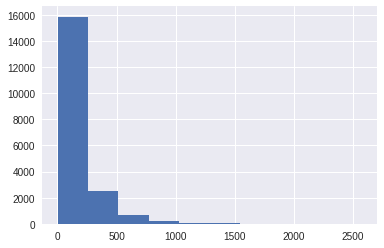

In [8]:
%matplotlib inline
plt.hist(df_train["user_id"].value_counts())

In [9]:
threshold = 30

user_for_general_model = register_count[(register_count <= threshold)].index
user_for_specific_model = register_count[(register_count > threshold)].index
print(len(user_for_general_model))
print(len(user_for_specific_model))

5351
14121


In [10]:
print(len(df_train))
print(len(df_test))

3000000
19918


In [11]:
d = pd.isnull(df_test).sum()
cols_w_na = d[d > 0].index

for column in cols_w_na:
    try:
        df_test[column] = df_test[column].fillna(df_train[column].mean(skipna=True))
    except:
        df_test[column].fillna(0, inplace=True)

print_full(pd.isnull(df_test).sum())

Unnamed: 0                           0
Unnamed: 0.1                         0
sample_id                            0
genre_id                             0
ts_listen                            0
media_id                             0
album_id                             0
context_type                         0
release_date                         0
platform_name                        0
platform_family                      0
media_duration                       0
listen_type                          0
user_gender                          0
user_id                              0
artist_id                            0
user_age                             0
text                                 0
year                                 0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
release_date_DAY                     0
release_date_MONTH                   0
release_date_YEAR                    0
ts_listen_DAY_OF_WEEK    

In [12]:
users = df_train["user_id"].unique()[:50]
from tqdm import tqdm
all_dfs = []

df_train["is_train"] = 1
df_train["sample_id"] = 1
df_test["is_train"] = 0
df_test["is_listened"] = 0

df_train_ = pd.concat([df_train, df_test])

#print(pd.isnull(df_train_).sum())

#print(pd.isnull(df_train_[df_train_["is_train"] == 0]).sum())

df_train_["is_listened"] = df_train_["is_listened"].apply(lambda x : float(x))
df_train_["listen_type"] = df_train_["listen_type"].apply(lambda x : float(x))
#print(len(df_train_))

for user in tqdm(user_for_specific_model[:]):
    df = df_train_[df_train_["user_id"] == user] #.copy(deep=True)
    #print(len(df))
    #df = df.sort("ts_listen")
    df = df.sort_values(by = "ts_listen")
    
    df["flow_listened"] = df["is_listened"] * df["listen_type"]
    df["flows_listened_last_10"] = df["flow_listened"].rolling(10).apply(lambda x : np.sum(x))
    df["flows_listened_mean_last_10"] = df["flow_listened"].rolling(10).apply(lambda x : np.mean(x))
    
    #print(df["flow_listened"].head())
    
    #print(df["flows_listened_mean_last_10"].head(15))
    
    #print(df["flow_listened"].head())
    #df.drop(["flow_listened"], axis=1, inplace=True)
    #print(pd.isnull(df).sum())
    
    #print(pd.isnull(df_train_[df_train_["is_train"] == 0]).sum())
    
    df["diff_last_ts_listen"] = df["ts_listen"].diff()
    df.dropna(inplace=True)
    
    
    df["diff_last_ts_listen"] = df["diff_last_ts_listen"].apply(lambda x : x.seconds / 3600.0)
    
    df, cols = delayed_data(df, ["diff_last_ts_listen", 
                                 "is_listened", 
                                 "listen_type", 
                                 "flow_listened",
                                 "flows_listened_last_10", 
                                 "flows_listened_mean_last_10"], 10)
    
    
    #print("null")
    #print(pd.isnull(df).sum().sum())
    df.drop(["flow_listened",
            "flows_listened_last_10",
            "flows_listened_mean_last_10"], axis=1, inplace=True)
    
    #print("len final: {}".format(len(df)))
    


    #print("len final: {}".format(len(df)))
    
    all_dfs.append(df)
    
df_train_ = pd.concat(all_dfs)
print(len(df_train_))
df_train_.head()

100%|██████████| 135/135 [00:19<00:00,  8.08it/s]


188506


,Unnamed: 0,Unnamed: 0.1,album_id,artist_albuns,artist_fans,artist_id,artist_radio,context_type,diff_ts_listen_AND_release_date_D,diff_ts_listen_AND_release_date_M,...,flows_listened_mean_last_10_delayed_1,flows_listened_mean_last_10_delayed_2,flows_listened_mean_last_10_delayed_3,flows_listened_mean_last_10_delayed_4,flows_listened_mean_last_10_delayed_5,flows_listened_mean_last_10_delayed_6,flows_listened_mean_last_10_delayed_7,flows_listened_mean_last_10_delayed_8,flows_listened_mean_last_10_delayed_9,flows_listened_mean_last_10_delayed_10
1064243,1064243,1064243,12599758,44.0,5231155.0,293585,1.0,0,235.0,7.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
1117361,1117361,1117361,12599760,7.0,144341.0,7890062,1.0,0,306.0,10.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2780987,2780987,2780993,10333912,31.0,3608525.0,249599,1.0,0,525.0,17.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986424,1986424,1986424,7294375,20.0,851006.0,2137231,1.0,0,998.0,33.266667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1177075,1177075,1177075,13726996,89.0,1777037.0,169361,1.0,0,88.0,2.933333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_test.head()

,Unnamed: 0,Unnamed: 0.1,sample_id,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,...,diff_user_song_age,media_decade,media_bpm,media_rank,artist_albuns,artist_fans,artist_radio,user_id_id,is_train,is_listened
0,0,0,0,50,2016-11-02 14:32:51,683078,82356,1,2002-10-08 00:00:00,0,...,15.920548,7,181.0,293191.0,25.0,31649.0,1.0,17698,0,0
1,1,1,1,2744,2016-11-16 15:25:40,876497,99692,1,1985-12-31 00:00:00,0,...,-2.898630,5,88.0,743839.0,10.0,585650.0,1.0,10525,0,0
2,2,2,2,2744,2016-11-19 07:06:01,876497,99692,1,1985-12-31 00:00:00,0,...,-3.906849,5,88.0,743839.0,10.0,585650.0,1.0,8716,0,0
3,3,3,3,2744,2016-11-06 16:42:09,876500,99692,1,1985-12-31 00:00:00,2,...,-0.871233,5,107.0,630042.0,10.0,585650.0,1.0,5443,0,0
4,4,4,4,2744,2016-11-29 17:42:40,876504,99692,1,1985-12-31 00:00:00,2,...,-1.934247,5,110.0,372256.0,10.0,585650.0,1.0,7600,0,0


In [14]:
df_train_["is_train"].head()

1064243    1
1117361    1
2780987    1
1986424    1
1177075    1
Name: is_train, dtype: int64

In [15]:
df_train = df_train_[df_train_["is_train"] == 1]
df_test = df_train_[df_train_["is_train"] == 0]
    
df_test.drop(["is_listened"], axis=1, inplace=True)

print(len(df_train))
print(len(df_test))

188371
135


/home/lgmoneda/miniconda2/envs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
print_full(df_train.dtypes[:])

Unnamed: 0                                         int64
Unnamed: 0.1                                       int64
album_id                                           int64
artist_albuns                                    float64
artist_fans                                      float64
artist_id                                          int64
artist_radio                                     float64
context_type                                       int64
diff_ts_listen_AND_release_date_D                float64
diff_ts_listen_AND_release_date_M                float64
diff_ts_listen_AND_release_date_Y                float64
diff_user_song_age                               float64
genre_id                                           int64
is_listened                                      float64
is_train                                           int64
listen_type                                      float64
media_bpm                                        float64
media_decade                   

In [17]:
df_train.head()

,Unnamed: 0,Unnamed: 0.1,album_id,artist_albuns,artist_fans,artist_id,artist_radio,context_type,diff_ts_listen_AND_release_date_D,diff_ts_listen_AND_release_date_M,...,flows_listened_mean_last_10_delayed_1,flows_listened_mean_last_10_delayed_2,flows_listened_mean_last_10_delayed_3,flows_listened_mean_last_10_delayed_4,flows_listened_mean_last_10_delayed_5,flows_listened_mean_last_10_delayed_6,flows_listened_mean_last_10_delayed_7,flows_listened_mean_last_10_delayed_8,flows_listened_mean_last_10_delayed_9,flows_listened_mean_last_10_delayed_10
1064243,1064243,1064243,12599758,44.0,5231155.0,293585,1.0,0,235.0,7.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
1117361,1117361,1117361,12599760,7.0,144341.0,7890062,1.0,0,306.0,10.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2780987,2780987,2780993,10333912,31.0,3608525.0,249599,1.0,0,525.0,17.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986424,1986424,1986424,7294375,20.0,851006.0,2137231,1.0,0,998.0,33.266667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1177075,1177075,1177075,13726996,89.0,1777037.0,169361,1.0,0,88.0,2.933333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df_test.head()
# ### select users for specific
# df_train = df_train[df_train["user_id"].isin(user_for_specific_model)]
# df_test = df_test[df_test["user_id"].isin(user_for_specific_model)]
# df_train.columns

,Unnamed: 0,Unnamed: 0.1,album_id,artist_albuns,artist_fans,artist_id,artist_radio,context_type,diff_ts_listen_AND_release_date_D,diff_ts_listen_AND_release_date_M,...,flows_listened_mean_last_10_delayed_1,flows_listened_mean_last_10_delayed_2,flows_listened_mean_last_10_delayed_3,flows_listened_mean_last_10_delayed_4,flows_listened_mean_last_10_delayed_5,flows_listened_mean_last_10_delayed_6,flows_listened_mean_last_10_delayed_7,flows_listened_mean_last_10_delayed_8,flows_listened_mean_last_10_delayed_9,flows_listened_mean_last_10_delayed_10
6026,6026,6026,10804138,14.0,104390.0,4052518,1.0,1,504.0,16.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9627,9627,9627,11516526,9.0,3506.0,5328949,1.0,1,363.0,12.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14561,14561,14561,12219078,5.0,297242.0,468920,1.0,1,416.0,13.866667,...,1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1
17323,17323,17323,11645048,5.0,253719.0,4944278,1.0,20,349.0,11.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7383,7383,7383,227814,2.0,23.0,16659,1.0,1,12023.0,400.766667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
to_drop = ['Unnamed: 0', 'Unnamed: 0.1']
df_train.drop(to_drop, axis = 1,inplace=True)
df_train.head()

/home/lgmoneda/miniconda2/envs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,album_id,artist_albuns,artist_fans,artist_id,artist_radio,context_type,diff_ts_listen_AND_release_date_D,diff_ts_listen_AND_release_date_M,diff_ts_listen_AND_release_date_Y,diff_user_song_age,...,flows_listened_mean_last_10_delayed_1,flows_listened_mean_last_10_delayed_2,flows_listened_mean_last_10_delayed_3,flows_listened_mean_last_10_delayed_4,flows_listened_mean_last_10_delayed_5,flows_listened_mean_last_10_delayed_6,flows_listened_mean_last_10_delayed_7,flows_listened_mean_last_10_delayed_8,flows_listened_mean_last_10_delayed_9,flows_listened_mean_last_10_delayed_10
1064243,12599758,44.0,5231155.0,293585,1.0,0,235.0,7.833333,0.643836,26.356164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
1117361,12599760,7.0,144341.0,7890062,1.0,0,306.0,10.200000,0.838356,26.161644,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2780987,10333912,31.0,3608525.0,249599,1.0,0,525.0,17.500000,1.438356,25.561644,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986424,7294375,20.0,851006.0,2137231,1.0,0,998.0,33.266667,2.734247,24.265753,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1177075,13726996,89.0,1777037.0,169361,1.0,0,88.0,2.933333,0.241096,26.758904,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
#pd.set_option('display.height', 1000)
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)
#pd.set_option("precision", 2)
df_train.head()

,album_id,artist_albuns,artist_fans,artist_id,artist_radio,context_type,diff_ts_listen_AND_release_date_D,diff_ts_listen_AND_release_date_M,diff_ts_listen_AND_release_date_Y,diff_user_song_age,...,flows_listened_mean_last_10_delayed_1,flows_listened_mean_last_10_delayed_2,flows_listened_mean_last_10_delayed_3,flows_listened_mean_last_10_delayed_4,flows_listened_mean_last_10_delayed_5,flows_listened_mean_last_10_delayed_6,flows_listened_mean_last_10_delayed_7,flows_listened_mean_last_10_delayed_8,flows_listened_mean_last_10_delayed_9,flows_listened_mean_last_10_delayed_10
1064243,12599758,44.0,5231155.0,293585,1.0,0,235.0,7.833333,0.643836,26.356164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
1117361,12599760,7.0,144341.0,7890062,1.0,0,306.0,10.200000,0.838356,26.161644,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2780987,10333912,31.0,3608525.0,249599,1.0,0,525.0,17.500000,1.438356,25.561644,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986424,7294375,20.0,851006.0,2137231,1.0,0,998.0,33.266667,2.734247,24.265753,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1177075,13726996,89.0,1777037.0,169361,1.0,0,88.0,2.933333,0.241096,26.758904,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# pd.isnull(df_train).sum()[pd.isnull(df_train).sum() > 0]

In [22]:
# df_train[df_train["release_date_YEAR"] == 1900][["media_id", "ts_listen"]]

In [23]:
# df_train[df_train["release_date_YEAR"] == 1900][["media_id", "ts_listen"]]

### Append User Specific

In [24]:
df_user = pd.read_csv("../data/nmidia_feats.csv", sep=";")
# pd.isnull(df_user).sum()[pd.isnull(df_user).sum() > 0]


#df_user = df_user.drop(["nmidia_with_flow_listened_PROP", "nmidia_regular_listened_PROP", "nmidia_PROP_diff"], axis=1)
df_user.fillna(0, inplace=True)

df_user["nmidia_PROP_diff"] = df_user['nmidia_with_flow_listened_PROP'] - df_user['nmidia_regular_listened_PROP']

df_user.columns.values

array(['user_id', 'nmidia_regular_listened', 'nmidia_with_flow_listened',
       'nmidia_regular', 'nmidia_with_flow',
       'nmidia_with_flow_listened_PROP', 'nmidia_regular_listened_PROP',
       'nmidia_PROP_diff'], dtype=object)

In [25]:
# x = pd.isnull(df_user).sum()
# x[x > 0]

In [26]:
df_train = pd.merge(df_train, df_user, on="user_id")
df_test = pd.merge(df_test, df_user, on="user_id")
df_train.head()

,album_id,artist_albuns,artist_fans,artist_id,artist_radio,context_type,diff_ts_listen_AND_release_date_D,diff_ts_listen_AND_release_date_M,diff_ts_listen_AND_release_date_Y,diff_user_song_age,...,flows_listened_mean_last_10_delayed_8,flows_listened_mean_last_10_delayed_9,flows_listened_mean_last_10_delayed_10,nmidia_regular_listened,nmidia_with_flow_listened,nmidia_regular,nmidia_with_flow,nmidia_with_flow_listened_PROP,nmidia_regular_listened_PROP,nmidia_PROP_diff
0,12599758,44.0,5231155.0,293585,1.0,0,235.0,7.833333,0.643836,26.356164,...,0.0,0.0,0.1,1745,1151,1772,1158,0.993955,0.984763,0.009192
1,12599760,7.0,144341.0,7890062,1.0,0,306.0,10.200000,0.838356,26.161644,...,0.0,0.0,0.0,1745,1151,1772,1158,0.993955,0.984763,0.009192
2,10333912,31.0,3608525.0,249599,1.0,0,525.0,17.500000,1.438356,25.561644,...,0.0,0.0,0.0,1745,1151,1772,1158,0.993955,0.984763,0.009192
3,7294375,20.0,851006.0,2137231,1.0,0,998.0,33.266667,2.734247,24.265753,...,0.0,0.0,0.0,1745,1151,1772,1158,0.993955,0.984763,0.009192
4,13726996,89.0,1777037.0,169361,1.0,0,88.0,2.933333,0.241096,26.758904,...,0.0,0.0,0.0,1745,1151,1772,1158,0.993955,0.984763,0.009192


### Check for NA
#### Ver depois sobre o user_age_group!

In [27]:
# x = pd.isnull(df_train).sum()
# x[x > 0]

In [28]:
# df_train.dropna(inplace=True)

In [29]:
# x = pd.isnull(df_train).sum()
# x[x > 0]
# del x

In [30]:
y = df_train["is_listened"].values

In [31]:
categorical_cols = ["genre_id",
                   "media_id",
                   "album_id",
                   "context_type",
                   "release_date",
                   "platform_name",
                   "platform_family",
                   "listen_type",
                   "user_gender",
                   "user_id",
                   "artist_id",
                   "user_age"]

In [32]:
print(len(df_train.columns))
print(len(set(df_train.columns)))

104
104


### Let's inspect the categorical variables!

In [33]:
for col in categorical_cols:
    print("{}: {}".format(col, len(df_train[col].unique())))

genre_id: 757
media_id: 23969
album_id: 11488
context_type: 52
release_date: 3570
platform_name: 3
platform_family: 3
listen_type: 2
user_gender: 2
user_id: 135
artist_id: 7706
user_age: 13


### Strategy
1. Apply onehot to categorical with few classes
2. Rank categories to artist id
3. target encoder for context and genre
4. discard media, album, release date and user_id

In [34]:
from greenpyce.feature_engineering import TargetEncoder
from greenpyce.feature_engineering import onehot
from greenpyce.feature_engineering import RankCategorical
from greenpyce.feature_engineering import LabelCount

In [35]:
df_train.columns.values

array(['album_id', 'artist_albuns', 'artist_fans', 'artist_id',
       'artist_radio', 'context_type', 'diff_ts_listen_AND_release_date_D',
       'diff_ts_listen_AND_release_date_M',
       'diff_ts_listen_AND_release_date_Y', 'diff_user_song_age',
       'genre_id', 'is_listened', 'is_train', 'listen_type', 'media_bpm',
       'media_decade', 'media_duration', 'media_id', 'media_rank',
       'platform_family', 'platform_name', 'release_date',
       'release_date_DAY', 'release_date_MONTH', 'release_date_YEAR',
       'sample_id', 'text', 'ts_listen', 'ts_listen_DAY_OF_WEEK',
       'ts_listen_PERIOD_OF_DAY', 'user_age', 'user_age_group',
       'user_gender', 'user_id', 'user_id_id', 'year',
       'diff_last_ts_listen', 'diff_last_ts_listen_delayed_1',
       'diff_last_ts_listen_delayed_2', 'diff_last_ts_listen_delayed_3',
       'diff_last_ts_listen_delayed_4', 'diff_last_ts_listen_delayed_5',
       'diff_last_ts_listen_delayed_6', 'diff_last_ts_listen_delayed_7',
       'diff_

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'genre_id', u'ts_listen', u'media_id',
       u'album_id', u'context_type', u'release_date', u'platform_name',
       u'platform_family', u'media_duration', u'listen_type', u'user_gender',
       u'user_id', u'artist_id', u'user_age', u'is_listened', u'text', u'year',
       u'diff_ts_listen_AND_release_date_D',
       u'diff_ts_listen_AND_release_date_M',
       u'diff_ts_listen_AND_release_date_Y', u'release_date_DAY',
       u'release_date_MONTH', u'release_date_YEAR', u'ts_listen_DAY_OF_WEEK',
       u'ts_listen_PERIOD_OF_DAY', u'user_age_group', u'diff_user_song_age',
       u'media_decade'],
      dtype='object')

('media_rank', 108554)
('media_bpm', 105514)
('diff_user_song_age', 100350)
('artist_fans', 99141)
('artist_albuns', 95015)
('album_id', 80906)
('diff_ts_listen_AND_release_date_Y', 77166)
('media_id', 73054)
('nmidia_regular_listened_PROP', 71187)
('nmidia_regular_listened', 69962)
('nmidia_PROP_diff', 64373)
('nmidia_with_flow_listened', 62142)
('nmidia_regular', 59499)
('nmidia_with_flow', 57739)
('user_id', 56269)
('nmidia_with_flow_listened_PROP', 55801)
('genre_id', 36985)
('context_type', 29875)
('ts_listen_PERIOD_OF_DAY_1', 26963)
('media_duration', 23570)
('release_date_YEAR', 18939)
('user_gender_1', 15002)
('ts_listen_PERIOD_OF_DAY_2', 10208)
('ts_listen_DAY_OF_WEEK_1', 9843)
('ts_listen_DAY_OF_WEEK_3', 9767)
('ts_listen_DAY_OF_WEEK_4', 9611)
('ts_listen_DAY_OF_WEEK_5', 9029)

In [36]:
cols_for_target_encoder = ["user_id"]

cols_for_onehot = ["platform_name", 
                   "platform_family", 
                   "user_age",
                   "listen_type",
                   "artist_radio",
                   "user_age_group",
                   "media_decade",
                   "user_gender", 
                   "ts_listen_DAY_OF_WEEK",
                   "ts_listen_PERIOD_OF_DAY"]

cols_for_rank = ["artist_id",
                 "genre_id",
                "artist_fans",
                "media_id", 
                 "album_id",
                "context_type"]


target = "is_listened"

In [37]:
te = TargetEncoder(cols_for_target_encoder, "is_listened")

In [38]:
te.fit(df_train)

In [39]:
te.transform(df_train)
te.transform(df_test)
del te

In [40]:
print("das")

das


In [41]:
print("teste")

teste


In [42]:
rc = RankCategorical(cols_for_rank)
rc.fit(df_train)
rc.transform(df_train)
rc.transform(df_test)
del rc

In [43]:
# rc = RankCategorical(["media_decade"])
# rc.fit(df_train)
# rc.transform(df_train)
# rc.transform(df_test)
# del rc

In [44]:
# lc = RankCategorical(cols_for_count)
# lc.fit(df_train)
# lc.transform(df_train)
# lc.transform(df_test)

In [45]:
df_train.head()

,album_id,artist_albuns,artist_fans,artist_id,artist_radio,context_type,diff_ts_listen_AND_release_date_D,diff_ts_listen_AND_release_date_M,diff_ts_listen_AND_release_date_Y,diff_user_song_age,...,flows_listened_mean_last_10_delayed_8,flows_listened_mean_last_10_delayed_9,flows_listened_mean_last_10_delayed_10,nmidia_regular_listened,nmidia_with_flow_listened,nmidia_regular,nmidia_with_flow,nmidia_with_flow_listened_PROP,nmidia_regular_listened_PROP,nmidia_PROP_diff
0,1043,44.0,161,162,1.0,1,235.0,7.833333,0.643836,26.356164,...,0.0,0.0,0.1,1745,1151,1772,1158,0.993955,0.984763,0.009192
1,36,7.0,73,73,1.0,1,306.0,10.200000,0.838356,26.161644,...,0.0,0.0,0.0,1745,1151,1772,1158,0.993955,0.984763,0.009192
2,57,31.0,66,66,1.0,1,525.0,17.500000,1.438356,25.561644,...,0.0,0.0,0.0,1745,1151,1772,1158,0.993955,0.984763,0.009192
3,103,20.0,125,125,1.0,1,998.0,33.266667,2.734247,24.265753,...,0.0,0.0,0.0,1745,1151,1772,1158,0.993955,0.984763,0.009192
4,2735,89.0,192,191,1.0,1,88.0,2.933333,0.241096,26.758904,...,0.0,0.0,0.0,1745,1151,1772,1158,0.993955,0.984763,0.009192


In [46]:
df_train = onehot(df_train, cols_for_onehot)
df_test = onehot(df_test, cols_for_onehot)

In [47]:
print(df_train.head())

   album_id  artist_albuns  artist_fans  artist_id  context_type  diff_ts_listen_AND_release_date_D  diff_ts_listen_AND_release_date_M  diff_ts_listen_AND_release_date_Y  diff_user_song_age  \
0      1043           44.0          161        162             1                              235.0                           7.833333                           0.643836           26.356164   
1        36            7.0           73         73             1                              306.0                          10.200000                           0.838356           26.161644   
2        57           31.0           66         66             1                              525.0                          17.500000                           1.438356           25.561644   
3       103           20.0          125        125             1                              998.0                          33.266667                           2.734247           24.265753   
4      2735           89.0         

In [48]:
#df_train = rank_categorical(df_train, cols_for_rank)
from collections import Counter
Counter(list(df_train.columns))

Counter({'album_id': 1,
         'artist_albuns': 1,
         'artist_fans': 1,
         'artist_id': 1,
         'context_type': 1,
         'diff_last_ts_listen': 1,
         'diff_last_ts_listen_delayed_1': 1,
         'diff_last_ts_listen_delayed_10': 1,
         'diff_last_ts_listen_delayed_2': 1,
         'diff_last_ts_listen_delayed_3': 1,
         'diff_last_ts_listen_delayed_4': 1,
         'diff_last_ts_listen_delayed_5': 1,
         'diff_last_ts_listen_delayed_6': 1,
         'diff_last_ts_listen_delayed_7': 1,
         'diff_last_ts_listen_delayed_8': 1,
         'diff_last_ts_listen_delayed_9': 1,
         'diff_ts_listen_AND_release_date_D': 1,
         'diff_ts_listen_AND_release_date_M': 1,
         'diff_ts_listen_AND_release_date_Y': 1,
         'diff_user_song_age': 1,
         'flow_listened_delayed_1': 1,
         'flow_listened_delayed_10': 1,
         'flow_listened_delayed_2': 1,
         'flow_listened_delayed_3': 1,
         'flow_listened_delayed_4': 1,
    

In [49]:
print(len(df_train.columns))
print(len(set(df_train.columns)))

131
131


In [50]:
df_train.columns.values

array(['album_id', 'artist_albuns', 'artist_fans', 'artist_id',
       'context_type', 'diff_ts_listen_AND_release_date_D',
       'diff_ts_listen_AND_release_date_M',
       'diff_ts_listen_AND_release_date_Y', 'diff_user_song_age',
       'genre_id', 'is_listened', 'is_train', 'media_bpm',
       'media_duration', 'media_id', 'media_rank', 'release_date',
       'release_date_DAY', 'release_date_MONTH', 'release_date_YEAR',
       'sample_id', 'text', 'ts_listen', 'user_id', 'user_id_id', 'year',
       'diff_last_ts_listen', 'diff_last_ts_listen_delayed_1',
       'diff_last_ts_listen_delayed_2', 'diff_last_ts_listen_delayed_3',
       'diff_last_ts_listen_delayed_4', 'diff_last_ts_listen_delayed_5',
       'diff_last_ts_listen_delayed_6', 'diff_last_ts_listen_delayed_7',
       'diff_last_ts_listen_delayed_8', 'diff_last_ts_listen_delayed_9',
       'diff_last_ts_listen_delayed_10', 'is_listened_delayed_1',
       'is_listened_delayed_2', 'is_listened_delayed_3',
       'is_listene

In [51]:
print(len(df_train.columns))
print(len(set(df_train.columns)))

131
131


In [52]:
%timeit
### Drop
to_drop = ['ts_listen', 'release_date', "year", "text", 'release_date_DAY', 'release_date_MONTH']#, "nmidia_with_flow_listened_PROP", "nmidia_PROP_diff", "nmidia_regular_listened_PROP"]
df_train.drop(to_drop, axis = 1,inplace=True)
df_test.drop(to_drop, axis = 1,inplace=True)

In [53]:
# to_drop = ["year", "text"]
# df_train.drop(to_drop, axis = 1,inplace=True)

In [54]:
ignore_list = [target, "user_id_id"]
features = [col for col in df_train.columns.values if col not in ignore_list]
features

['album_id',
 'artist_albuns',
 'artist_fans',
 'artist_id',
 'context_type',
 'diff_ts_listen_AND_release_date_D',
 'diff_ts_listen_AND_release_date_M',
 'diff_ts_listen_AND_release_date_Y',
 'diff_user_song_age',
 'genre_id',
 'is_train',
 'media_bpm',
 'media_duration',
 'media_id',
 'media_rank',
 'release_date_YEAR',
 'sample_id',
 'user_id',
 'diff_last_ts_listen',
 'diff_last_ts_listen_delayed_1',
 'diff_last_ts_listen_delayed_2',
 'diff_last_ts_listen_delayed_3',
 'diff_last_ts_listen_delayed_4',
 'diff_last_ts_listen_delayed_5',
 'diff_last_ts_listen_delayed_6',
 'diff_last_ts_listen_delayed_7',
 'diff_last_ts_listen_delayed_8',
 'diff_last_ts_listen_delayed_9',
 'diff_last_ts_listen_delayed_10',
 'is_listened_delayed_1',
 'is_listened_delayed_2',
 'is_listened_delayed_3',
 'is_listened_delayed_4',
 'is_listened_delayed_5',
 'is_listened_delayed_6',
 'is_listened_delayed_7',
 'is_listened_delayed_8',
 'is_listened_delayed_9',
 'is_listened_delayed_10',
 'listen_type_delayed_1'

In [55]:
pd.isnull(df_train).sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [56]:
import numpy as np
np.sum(np.isinf(df_train))

album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   0
genre_id                             0
is_listened                          0
is_train                             0
media_bpm                            0
media_duration                       0
media_id                             0
media_rank                           0
release_date_YEAR                    0
sample_id                            0
user_id                              0
user_id_id                           0
diff_last_ts_listen                  0
diff_last_ts_listen_delayed_1        0
diff_last_ts_listen_delayed_2        0
diff_last_ts_listen_delayed_3        0
diff_last_ts_listen_delayed_4        0
diff_last_ts_listen_delay

In [57]:
print_full(pd.isnull(df_test).sum()[:])

Unnamed: 0                                0
Unnamed: 0.1                              0
album_id                                  0
artist_albuns                             0
artist_fans                               0
artist_id                                 0
context_type                              0
diff_ts_listen_AND_release_date_D         0
diff_ts_listen_AND_release_date_M         0
diff_ts_listen_AND_release_date_Y         0
diff_user_song_age                        0
genre_id                                  0
is_train                                  0
media_bpm                                 0
media_duration                            0
media_id                                  0
media_rank                                0
release_date_YEAR                         0
sample_id                                 0
user_id                                   0
user_id_id                                0
diff_last_ts_listen                       0
diff_last_ts_listen_delayed_1   

In [58]:
np.sum(np.isinf(df_test)).values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [59]:
for column in features:
    try:
        df_test[column] = df_test[column].fillna(df_train[column].mean(skipna=True))
    except:
        df_test[column] = 0

#df_test = df_test.fillna(df_train.mean(skipna=True), axis=1)
df_test = df_test.applymap(lambda x : float(x))
pd.isnull(df_test).sum().sum()

0

In [60]:
np.sum(np.isinf(df_test)).values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [61]:
# df_train.fillna(0, inplace=True)
# df_test.fillna(0, inplace=True)

In [62]:
# pd.isnull(df_train).sum()

In [63]:
from sklearn.model_selection import train_test_split
features = list(set(features))

In [64]:
# features = ['media_duration',
#  'user_id',
#  'artist_id',
#  'diff_ts_listen_AND_release_date_M',
#  'diff_ts_listen_AND_release_date_Y',
#  'release_date_YEAR',
#  'diff_user_song_age',
#  'artist_albuns',
#  'artist_fans',
#  'media_bpm',
#  'media_rank',
#  'nmidia_regular_listened',
#  'nmidia_with_flow_listened',
#  'nmidia_regular',
#  'nmidia_with_flow',
#  'nmidia_with_flow_listened_PROP',
#  'nmidia_regular_listened_PROP',
#  'nmidia_PROP_diff',
#  'listen_type_1',
#  'user_gender_1',
#  'ts_listen_DAY_OF_WEEK_1',
#  'ts_listen_DAY_OF_WEEK_2',
#  'ts_listen_DAY_OF_WEEK_3',
#  'ts_listen_DAY_OF_WEEK_4',
#  'ts_listen_DAY_OF_WEEK_5',
#  'ts_listen_DAY_OF_WEEK_6',
#  'ts_listen_PERIOD_OF_DAY_1',
#  'ts_listen_PERIOD_OF_DAY_2',
#  'ts_listen_PERIOD_OF_DAY_3']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[target], test_size = 0.2)
import gc
gc.collect()

68

### Feature Selection

In [66]:
from sklearn import feature_selection
all_features = features
function_rule_selection = feature_selection.f_classif
alpha_cutoff = 0.01

selection_rule = feature_selection.SelectFdr(function_rule_selection, alpha_cutoff)
selection_rule.fit(X_train, y_train);

all_pvalues = list(filter(lambda x: pd.notnull(x[0]), zip(selection_rule.pvalues_, all_features)))
#print(all_pvalues)
filtered_pvalues = list(filter(lambda x: x[0]<=alpha_cutoff, all_pvalues))
#print(filtered_pvalues)
all_select_features = list(map(lambda x: x[1], filtered_pvalues))

print("{0} selected variables from {1}, {2:.2f}%".format(len(all_select_features), 
                                                        len(all_features), 
                                                        len(filtered_pvalues)*100/float(len(all_features))))
print(all_select_features)
#print(filtered_pvalues)

107 selected variables from 123, 86.99%
['diff_user_song_age', 'flows_listened_mean_last_10_delayed_2', 'flows_listened_mean_last_10_delayed_3', 'flows_listened_mean_last_10_delayed_1', 'flows_listened_mean_last_10_delayed_6', 'media_duration', 'flows_listened_mean_last_10_delayed_4', 'flows_listened_mean_last_10_delayed_5', 'flows_listened_mean_last_10_delayed_8', 'flows_listened_mean_last_10_delayed_9', 'flows_listened_mean_last_10_delayed_10', 'nmidia_with_flow', 'diff_last_ts_listen', 'flows_listened_last_10_delayed_3', 'flows_listened_last_10_delayed_2', 'flows_listened_last_10_delayed_1', 'flows_listened_last_10_delayed_7', 'flows_listened_last_10_delayed_6', 'flows_listened_last_10_delayed_5', 'flows_listened_last_10_delayed_4', 'flows_listened_last_10_delayed_9', 'flows_listened_last_10_delayed_8', 'flows_listened_mean_last_10_delayed_7', 'album_id', 'diff_last_ts_listen_delayed_9', 'diff_last_ts_listen_delayed_8', 'flow_listened_delayed_10', 'diff_last_ts_listen_delayed_1', 'd

/home/lgmoneda/miniconda2/envs/ml/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [59 66] are constant.
  UserWarning)
/home/lgmoneda/miniconda2/envs/ml/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [67]:
features = all_select_features
X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[target], test_size = 0.2)

In [68]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def complete_report(y_test, y_pred):
    print("*********************************")
    print("Accuracy: {0:.2f}".format(accuracy_score(y_test, y_pred)))
    print("Precision: {0}".format(metrics.precision_score(y_test, y_pred)))
    print("Recall: {0}".format(metrics.recall_score(y_test, y_pred)))
    print("F1-Score: {0}".format(metrics.f1_score(y_test, y_pred)))
    conf_m = confusion_matrix(y_test, y_pred)
    print(conf_m)
    try: 
        print("Roc Area: {0}".format(metrics.roc_auc_score(y_test, y_pred))) 
        roc_curve_label(y_test, y_pred)
    except:
        print("--")
    print("*********************************")
    
    return metrics.roc_auc_score(y_test, y_pred)
        
def roc_curve_label(y_test, y_pred):
    plt.figsize=(10,6)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='RT + LR')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [69]:
# %timeit
# from sklearn.tree import DecisionTreeClassifier
# model = DecisionTreeClassifier()
# model.fit(X_train, y_train)

In [70]:
# print(model.score(X_test, y_test))
# complete_report(y_test, model.predict(X_test))
print(len(X_train.columns))
print(len(set(X_train.columns)))

107
107


In [71]:
print(len(features))
print(len(set(features)))

107
107


acc: 0.70345496362865445  
roc: 0.6912675674785278

In [72]:
from sklearn.metrics import confusion_matrix

*********************************
Accuracy: 0.86
Precision: 0.91526283375
Recall: 0.897382161759
F1-Score: 0.906234306622
[[ 7183  2339]
 [ 2889 25264]]
Roc Area: 0.825870244921


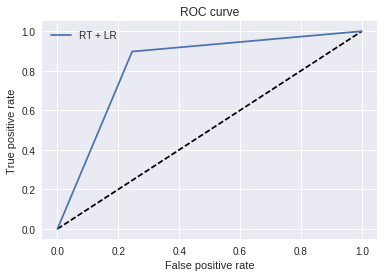

*********************************


0.82587024492064776

In [74]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train, y_train)
model.score(X_test, y_test)
complete_report(y_test, model.predict(X_test))

In [75]:
len(X_train.columns)

107

In [77]:
X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[target], test_size = 0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

In [83]:
import xgboost as xgb
from time import time
import numpy as np

start = time()
xg_train = xgb.DMatrix(X_train, label=y_train.values, missing=np.NaN)
xg_test = xgb.DMatrix(X_test, label=y_test.values, missing=np.NaN)
xg_val = xgb.DMatrix(X_val, label=y_val.values, missing=np.NaN)
param = {'max_depth':50, 
         'eta':0.2, 
         'silent':0, 
         'objective':'binary:logistic', 
         "booster": "gbtree", 
         "max_delta_step":1,
         "alpha": 0.2,
         "lambda": 0.2,
         #"scale_pos_weight": class_ratio,
         "eval_metric": "auc",
          "verbose": 1}

### Objectives
## 'binary:logistic'
## 'multi:softprob'
#param['num_class'] = 2
param["min_child_weight"] = 30
param["colsample_bytree"] = 0.5
num_round = 30

watchlist = [(xg_train,'train'), (xg_test,'test'), (xg_val,'validation')]
#watchlist = [(xg_val,'validation')]

bst = xgb.train(param, 
                xg_train, 
                num_round,
                watchlist,
                early_stopping_rounds=5)

yprob = bst.predict( xg_test ) #.reshape( y_test.shape[0], 2)
print(yprob[0])

print('Tempo de execução: {0}m{1}s'.format(int((time()-start)/60),
             int((time()-start)%60 )))

[0]	train-auc:0.864605	test-auc:0.857573	validation-auc:0.858411
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 5 rounds.
[1]	train-auc:0.90327	test-auc:0.895986	validation-auc:0.896608
[2]	train-auc:0.916568	test-auc:0.910364	validation-auc:0.908504
[3]	train-auc:0.92217	test-auc:0.915079	validation-auc:0.913548
[4]	train-auc:0.926543	test-auc:0.919005	validation-auc:0.917168
[5]	train-auc:0.930337	test-auc:0.92184	validation-auc:0.92152
[6]	train-auc:0.934056	test-auc:0.924865	validation-auc:0.924454
[7]	train-auc:0.936758	test-auc:0.927037	validation-auc:0.926761
[8]	train-auc:0.938843	test-auc:0.928288	validation-auc:0.928578
[9]	train-auc:0.942428	test-auc:0.930717	validation-auc:0.930806
[10]	train-auc:0.943816	test-auc:0.93127	validation-auc:0.931422
[11]	train-auc:0.945413	test-auc:0.932014	validation-auc:0.931951
[12]	train-auc:0.946862	test-auc:0.932278	validation-auc:0.93209
[13]	t

In [84]:
y_pred = [1 if y > 0.5 else 0 for y in yprob]
#print(metrics.confusion_matrix(y_test, y_pred))
yprob = bst.predict( xg_test ) 
#complete_report(y_test, yprob)
len(yprob)

### Verificando a importância de cada feature para a previsão do modelo
import operator
importance = bst.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
for item in importance:
    print(item)

('media_id', 633)
('media_rank', 526)
('diff_last_ts_listen', 458)
('diff_last_ts_listen_delayed_6', 440)
('diff_ts_listen_AND_release_date_Y', 433)
('diff_last_ts_listen_delayed_1', 364)
('diff_user_song_age', 354)
('diff_last_ts_listen_delayed_3', 351)
('album_id', 344)
('diff_last_ts_listen_delayed_2', 328)
('diff_last_ts_listen_delayed_5', 321)
('media_bpm', 318)
('nmidia_with_flow_listened_PROP', 282)
('nmidia_regular_listened_PROP', 273)
('nmidia_with_flow', 272)
('diff_last_ts_listen_delayed_9', 254)
('diff_last_ts_listen_delayed_8', 246)
('diff_last_ts_listen_delayed_10', 242)
('diff_ts_listen_AND_release_date_M', 237)
('user_id', 212)
('nmidia_PROP_diff', 204)
('nmidia_regular', 197)
('nmidia_regular_listened', 175)
('nmidia_with_flow_listened', 153)
('context_type', 110)
('genre_id', 108)
('diff_ts_listen_AND_release_date_D', 87)
('media_duration', 63)
('flows_listened_mean_last_10_delayed_1', 60)
('flows_listened_last_10_delayed_1', 55)
('is_listened_delayed_5', 52)
('listen

*********************************
Accuracy: 0.88
Precision: 0.916827126286
Recall: 0.920501697473
F1-Score: 0.918660737394
[[ 5277  1771]
 [ 1686 19522]]
Roc Area: 0.834612369735


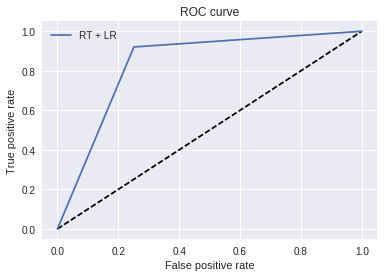

*********************************


0.83461236973519082

In [85]:
complete_report(y_test, y_pred)

In [86]:
df_test_group_1 = df_test[df_test["user_id_id"].isin(user_for_specific_model)].copy(deep=True)
xg_sub = xgb.DMatrix(df_test_group_1[features], missing=np.NaN)
p = bst.predict(xg_sub)

#p = model.predict_proba(df_test_group_1[features])
#p = p[:, 1]
df_test_group_1["prediction"] = p
df_test_group_1["prediction"].head()

0    0.976637
1    0.925276
2    0.972263
3    0.364014
4    0.895846
Name: prediction, dtype: float32

In [87]:
print(len(df_test))
print(len(df_test_group_1))
df_test_group_1[["prediction", "user_id_id"]]
df_test_group_1[["prediction", "user_id_id"]].to_csv("group1.csv")

135
135


In [88]:
import gc
gc.collect()
del df_test_group_1

In [89]:
import pandas as pd
from greenpyce.feature_engineering import TargetEncoder
from greenpyce.feature_engineering import onehot
from greenpyce.feature_engineering import RankCategorical
from greenpyce.feature_engineering import LabelCount
df_train = pd.read_csv("../data/train_data4.csv")
df_test = pd.read_csv("../data/test_data4.csv")

df_train["user_id_id"] = df_train["user_id"]
df_test["user_id_id"] = df_test["user_id"]

to_drop = ['Unnamed: 0', 'Unnamed: 0.1']
df_train.drop(to_drop, axis = 1,inplace=True)

# df_user = pd.read_csv("../data/nmidia_feats.csv", sep=";")
# # pd.isnull(df_user).sum()[pd.isnull(df_user).sum() > 0]
# df_user = df_user.drop(["nmidia_with_flow_listened_PROP", "nmidia_regular_listened_PROP", "nmidia_PROP_diff"], axis=1)
# df_user.columns.values
# df_train = pd.merge(df_train, df_user, on="user_id")
# df_test = pd.merge(df_test, df_user, on="user_id")
# del df_user


### select users for general

#df_train = df_train[df_train["user_id"].isin(user_for_general_model)]

threshold = 30

register_count = df_train["user_id"].value_counts()

user_for_general_model = register_count[(register_count <= threshold)].index
user_for_specific_model = register_count[(register_count > threshold)].index
print(len(user_for_general_model))
print(len(user_for_specific_model))

cols_for_target_encoder = ["genre_id", 
                           "media_id", 
                           "artist_radio"]

cols_for_onehot = ["platform_name", 
                   "user_age",
                   "listen_type",
                   "user_gender", 
                   "ts_listen_DAY_OF_WEEK",
                  "ts_listen_PERIOD_OF_DAY"]

cols_for_rank = ["artist_id",
                "artist_fans"]

target = "is_listened"

df_test = df_test[df_test["user_id"].isin(user_for_general_model)]
df_train.columns

te = TargetEncoder(cols_for_target_encoder, "is_listened")
te.fit(df_train)
te.transform(df_train)
te.transform(df_test)
del te

rc = RankCategorical(cols_for_rank)
rc.fit(df_train)
rc.transform(df_train)
rc.transform(df_test)
del rc

rc = RankCategorical(["media_decade"])
rc.fit(df_train)
rc.transform(df_train)
rc.transform(df_test)
del rc

df_train = onehot(df_train, cols_for_onehot)
df_test = onehot(df_test, cols_for_onehot)

%timeit
### Drop
to_drop = ['ts_listen', 'album_id', 'release_date', 'artist_id', "year", "text"]#, "nmidia_with_flow_listened_PROP", "nmidia_PROP_diff", "nmidia_regular_listened_PROP"]
df_train.drop(to_drop, axis = 1,inplace=True)
df_test.drop(to_drop, axis = 1,inplace=True)

features = [col for col in df_train.columns.values if col != target]
features

KeyboardInterrupt: 

In [ ]:
features

In [ ]:
len(df_test)

In [ ]:
# features =['genre_id', 
#            'media_id', 
#            'context_type', 
#     #       'media_duration', 
#            'listen_type', 
#     #       'user_id', 
#    #        'diff_ts_listen_AND_release_date_D', 
#            'diff_ts_listen_AND_release_date_M', 
#    #        'diff_ts_listen_AND_release_date_Y', 
#     #       'release_date_YEAR', 
#            'diff_user_song_age', 
#            'artist_albuns', 
#            'artist_fans', 
#            'artist_radio', 
#            'media_bpm', 
#            'media_rank', 
#            #'user_id_id', 
# #            'nmidia_regular_listened', 
# #            'nmidia_with_flow_listened', 
# #            'nmidia_regular', 
# #            'nmidia_with_flow', 
#            'platform_name_1', 
#            'platform_name_2', 
#            'platform_family_1', 
#            'platform_family_2', 
#            'user_age_19', 
#            'user_age_20', 
#            'user_age_21', 
#            'user_age_22', 
#            'user_age_23', 
#            'user_age_25', 
#            'user_age_26', 
#            'user_age_27', 
#            'user_age_28', 
#            'user_age_29', 
#            'user_age_30', 
#            'user_age_group_1',
#            'user_age_group_2', 
# #            'media_decade_1', 
#            'media_decade_2',
#            'media_decade_5', 
#            'media_decade_7', 
#            'media_decade_8', 
#            'user_gender_1', 
#            'user_age_group_1', 
#            'user_age_group_2', 
#            'ts_listen_DAY_OF_WEEK_1',
#            'ts_listen_DAY_OF_WEEK_2', 
#            'ts_listen_DAY_OF_WEEK_3', 
#            'ts_listen_DAY_OF_WEEK_4', 
#            'ts_listen_DAY_OF_WEEK_5',
#            'ts_listen_PERIOD_OF_DAY_2', 
#            'ts_listen_PERIOD_OF_DAY_3']

['genre_id', 'media_id', 'context_type', 'media_duration', 'listen_type', 'user_id', 'diff_ts_listen_AND_release_date_D', 'diff_ts_listen_AND_release_date_M', 'diff_ts_listen_AND_release_date_Y', 'release_date_YEAR', 'diff_user_song_age', 'artist_albuns', 'artist_fans', 'artist_radio', 'media_bpm', 'media_rank', 'user_id_id', 'nmidia_regular_listened', 'nmidia_with_flow_listened', 'nmidia_regular', 'nmidia_with_flow', 'platform_name_1', 'platform_name_2', 'platform_family_1', 'platform_family_2', 'user_age_19', 'user_age_20', 'user_age_21', 'user_age_22', 'user_age_23', 'user_age_25', 'user_age_26', 'user_age_27', 'user_age_28', 'user_age_29', 'user_age_30', 'user_age_group_1', 'user_age_group_2', 'media_decade_1', 'media_decade_2', 'media_decade_5', 'media_decade_7', 'media_decade_8', 'user_gender_1', 'user_age_group_1', 'user_age_group_2', 'ts_listen_DAY_OF_WEEK_1', 'ts_listen_DAY_OF_WEEK_2', 'ts_listen_DAY_OF_WEEK_3', 'ts_listen_DAY_OF_WEEK_4', 'ts_listen_DAY_OF_WEEK_5', 'ts_listen_PERIOD_OF_DAY_2', 'ts_listen_PERIOD_OF_DAY_3']

In [ ]:
### 0.7678

for column in features:
    try:
        df_test[column] = df_test[column].fillna(df_train[column].mean(skipna=True))
    except:
        df_test[column] = 0

#df_test = df_test.fillna(df_train.mean(skipna=True), axis=1)
df_test = df_test.applymap(lambda x : float(x))
pd.isnull(df_test).sum().sum()

In [ ]:
# df_test = df_test.fillna(df_train.mean(skipna=True).to_dict, axis=1)#.dropna(axis=1, how='all')
# pd.isnull(df_test).sum()
# df_train.mean(skipna=True).to_dict
features = ['media_duration',
 'artist_id',
 'diff_ts_listen_AND_release_date_M',
 'diff_user_song_age',
 'artist_albuns',
 'artist_fans',
 'media_bpm',
 'media_rank',
 'listen_type_1',
 'user_gender_1',
 'ts_listen_DAY_OF_WEEK_1',
 'ts_listen_DAY_OF_WEEK_2',
 'ts_listen_DAY_OF_WEEK_3',
 'ts_listen_DAY_OF_WEEK_4',
 'ts_listen_DAY_OF_WEEK_5',
 'ts_listen_DAY_OF_WEEK_6',
 'ts_listen_PERIOD_OF_DAY_1',
 'ts_listen_PERIOD_OF_DAY_2',
 'ts_listen_PERIOD_OF_DAY_3']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[target], test_size = 0.2)

from sklearn import feature_selection
all_features = features
function_rule_selection = feature_selection.f_classif
alpha_cutoff = 0.001

selection_rule = feature_selection.SelectFdr(function_rule_selection, alpha_cutoff)
selection_rule.fit(X_train, y_train);

all_pvalues = list(filter(lambda x: pd.notnull(x[0]), zip(selection_rule.pvalues_, all_features)))
#print(all_pvalues)
filtered_pvalues = list(filter(lambda x: x[0]<=alpha_cutoff, all_pvalues))
#print(filtered_pvalues)
all_select_features = list(map(lambda x: x[1], filtered_pvalues))

print("{0} selected variables from {1}, {2:.2f}%".format(len(all_select_features), 
                                                        len(all_features), 
                                                        len(filtered_pvalues)*100/float(len(all_features))))
print(all_select_features)
#print(filtered_pvalues)

features = all_select_features
X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[target], test_size = 0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

In [ ]:
import xgboost as xgb
from time import time
import numpy as np

start = time()
xg_train = xgb.DMatrix(X_train, label=y_train.values, missing=np.NaN)
xg_test = xgb.DMatrix(X_test, label=y_test.values, missing=np.NaN)
xg_val = xgb.DMatrix(X_val, label=y_val.values, missing=np.NaN)
param = {'max_depth':5, 
         'eta':0.2, 
         'silent':0, 
         'objective':'binary:logistic', 
         "booster": "gbtree", 
         "max_delta_step":1,
         "alpha": 0,
         "lambda": 0,
         #"scale_pos_weight": class_ratio,
         "eval_metric": "auc",
          "verbose": 1}

### Objectives
## 'binary:logistic'
## 'multi:softprob'
#param['num_class'] = 2
param["min_child_weight"] = 30
param["colsample_bytree"] = 0.5
num_round = 300

watchlist = [(xg_train,'train'), (xg_test,'test'), (xg_val,'validation')]
#watchlist = [(xg_val,'validation')]

bst = xgb.train(param, 
                xg_train, 
                num_round,
                watchlist,
                early_stopping_rounds=5)

yprob = bst.predict( xg_test ) #.reshape( y_test.shape[0], 2)
print(yprob[0])

print('Tempo de execução: {0}m{1}s'.format(int((time()-start)/60),
             int((time()-start)%60 )))

In [ ]:
df_test_group_2 = df_test[df_test["user_id_id"].isin(user_for_general_model)].copy(deep=True)
xg_sub = xgb.DMatrix(df_test_group_2[features], missing=np.NaN)
p = bst.predict(xg_sub)
df_test_group_2["prediction"] = p
df_test_group_2["prediction"].head()

In [ ]:
df_test_group_2[["user_id_id", "prediction"]].to_csv("group2.csv")

In [ ]:
df_test_group_1 = pd.read_csv("group1.csv", index_col="user_id_id")
df_test_group_2 = pd.read_csv("group2.csv", index_col="user_id_id")

In [ ]:
df_test = pd.read_csv("../data/test_data4.csv")
#df_test = df_test["user_id"]
#df_test["user_id_id"] = df_test["user_id"]
# df_test = pd.merge(df_test, df_test_group_1[["user_id", "prediction"]], on="user_id")
# df_test = pd.merge(df_test, df_test_group_2[["user_id", "prediction"]], on="user_id")
df_test = pd.merge(df_test, df_test_group_1[["prediction"]], left_on="user_id", right_index=True, how="outer")
#df_test.join(df_test_group_2[["prediction"]])
df_test = pd.merge(df_test, df_test_group_2[["prediction"]], left_on="user_id", right_index=True, how="outer")

In [ ]:
print(len(df_test_group_1))
print(len(df_test_group_2))
print(len(df_test))

In [ ]:
#pd.set_option("precision", 10)
#df_test_group_2[["user_id", "prediction"]].head()
a = pd.read_csv("../data/test_data4.csv")

In [ ]:
a["user_id"].head()

In [ ]:
df_test.head()

In [ ]:
df_test["prediction_x"].fillna(0, inplace=True)
df_test["prediction_y"].fillna(0, inplace=True)
df_test["prediction"] = df_test["prediction_x"] + df_test["prediction_y"]

In [ ]:
df_test["prediction"].head()

In [ ]:
df_test.ix[8716]["prediction"]

In [ ]:
df_test["prediction"].values[:5]

In [ ]:
len(df_test)

In [ ]:
(df_test["prediction"] > 1.0).sum()

In [ ]:
(df_test["prediction"] == 1.0).sum()

In [ ]:
(df_test["prediction"] == 0).sum()

In [ ]:
pd.isnull(df_test["prediction_y"]).sum()

In [ ]:
#df_test["prediction"] = df_test["prediction"].apply(lambda x : 1 if x > 1 else x)

In [ ]:
import gzip
import csv
import numpy as np

def build_kaggle_submission(preds, filename="my_submission"):
    """
    Build a compressed Kaggle Submission
    
    preds: array with predictions
    """
    with gzip.open(filename + '.csv.gz', 'wt') as outf:
        fo = csv.writer(outf, lineterminator='\n')
        fo.writerow(["sample_id", "is_listened"])       
        for i, pred in enumerate(preds):
            fo.writerow([i, pred])

In [ ]:
#p = model.predict_proba(df_test[features])
#p = p[:, 1]
p = df_test["prediction"].values

In [ ]:
build_kaggle_submission(p, "note20_1")

In [ ]:
import sys
print(sys.getsizeof(df_train) / 1e6)
print(sys.getsizeof(df_test) / 1e6)
print(sys.getsizeof(model) / 1e6)

In [ ]:
!ls